# Part 3 - Calculation of the Period and overall Transit Time 

In [98]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import scipy.signal as sig
from scipy.signal import argrelextrema
import emcee
#import ipdb

import corner
import scipy as sp
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=True)

In [99]:
physical = pd.read_excel('Physical.xlsx', sheetname='Sheet1')
targetParams = pd.read_excel('Results.xlsx', sheetname='TAP')


class Star:    
    def __init__(self, name, midts, per, per_err, mass, mass_err, radius,
                 radius_err, teff, teff_err, logg, feh, b, b_err, rprs, rp,timeLC, fluxLC):
        
        self.name = name
        self.midts = midts
        self.ecc = 0.0
        self.per = per
        self.per_err = per_err
        
        self.mass = mass
        self.mass_err = mass_err
        self.radius = radius
        self.radius_err = radius_err
        
        self.teff = teff
        self.teff_err = teff_err
        self.logg = logg
        self.feh = feh
        
        self.b = b
        self.b_err = b_err
        self.rprs = rprs
        self.depth = rprs ** 2 # Transit depth in absolute terms. To 1st order (assuming stellar disk has uniform brightness and neglecting any flux coming from planet), the ratio X of the observed change in flux, Delta(F), to that of the stellar flux F is: X = (Rp/Rs)^2 = depth.
        
        self.rp = rp #Earth radii
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. Rp needs to be in Earth radii
        
        #self.lld = lld # Linear LD coeff (Joey)
        #self.qld = qld # Quadratic LD coeff (Joey)  
        
        self.u1 = 0.0 # Claret
        self.u2 = 0.0 # Claret
        self.diffld = u2 - u1
        
        self.timeLC = timeLC
        self.fluxLC = fluxLC
        
        self.transits = np.empty(0)
        self.transRange = np.empty(0)
        self.transWindow = np.empty(0)
        self.flag = np.empty(0)
        self.f_trans = np.empty(0)
        self.t_trans = np.empty(0)
        self.dt = np.empty(0)
        self.error_foldedLC = np.empty(0)
        self.error_foldedLC_final = np.empty(0)
        
        
        self.optimize1 = np.empty(0)
       
        #Part 2
        self.dfdt = np.empty(0)
        self.t0fit = np.empty(0)
        self.f0fit = np.empty(0)
        self.dfdtfit = np.empty(0)
        self.sigmafit = np.empty(0)
        
        self.t0fit_MCMC = np.empty(0) 
        self.f0fit_MCMC = np.empty(0) 
        self.dfdtfit_MCMC = np.empty(0) 
        self.sigmafit_MCMC = np.empty(0) 
       
        self.p_final = 0.0
        self.t0_final = 0.0
        
    def Print(self):
        print("Star {}".format(self.name))

In [100]:
num = 12

In [101]:
tKep = 29.42/(60.0*24.0)
transit_range = np.array([0.4, 0.18, 0.07, 0.15, 0.12, 0.08, 0.08, 0.12, 0.15, 0.08, 0.18, 0.15])
tr_window = transit_range+transit_range # In days

In [102]:
targets = []
for i in range(0,num):
    name = "%.0f" % targetParams["EPIC"][i]
    midts = targetParams["midts"][i]
    per = targetParams["per"][i] #days
    
    per_lo = targetParams["per_lo"][i]
    per_hi = targetParams["per_hi"][i]
    per_err = np.mean([per_lo, per_hi])
    
    # Stellar mass
    mass = physical["mass"][i]
    mass_lo = physical["mass_lo"][i]
    mass_hi = physical["mass_hi"][i]
    mass_err = np.mean([mass_lo, mass_hi])
    
    # Stellar radius 
    radius = physical["radius"][i]
    radius_lo = physical["radius_lo"][i]
    radius_hi = physical["radius_hi"][i]
    radius_err = np.mean([radius_lo, radius_hi])
    
    #Effective temperature (In Kelvin)
    teff = physical["Teff"][i]
    teff_lo = physical["Teff_lo"][i]
    teff_hi = physical["Teff_hi"][i]
    teff_err = np.mean([teff_lo, teff_hi])
    
    #Logg
    logg = physical["logg"][i]
    feh = physical["feh"][i]
    
    # Impact parameter b
    b = targetParams["b"][i]
    b_lo = targetParams["b_lo"][i]
    b_hi = targetParams["b_hi"][i]
    b_err = np.mean([b_lo, b_hi])
        
    rprs = targetParams["rp/rs"][i] # Ratio Rp/Rs
    rprs_lo = targetParams["rp/rs_lo"][i]
    rprs_hi = targetParams["rp/rs_hi"][i]
    rprs_err = np.mean([rprs_lo, rprs_hi])
    
    rp = targetParams["rp"][i] # Planetary radius (Earth radii)
    
    u1 = 0.0
    u2 = 0.0
    
    #lld = targetParams["LLD"][i] # Linear 
    #qld = targetParams["QLD"][i] # Quadratic
    
    # This will upload LC data
    data = pd.read_table(name+"transits.csv", sep=',', dtype = {'flux': np.float64}, header = None, names=['time', 'flux'])
    
    timeLC = data['time']
    fluxLC = data['flux']

    trange = transit_range[i]
    twind = tr_window[i]
 
    star = Star(name, midts, per, per_err, mass, mass_err, radius, 
               radius_err, teff, teff_err, logg, feh, b, b_err, rprs, rp, timeLC, fluxLC)
    
    star.transRange = trange
    star.transWindow = twind 
     
    targets.append(star)

In [103]:
import kplr
from kplr.ld import get_quad_coeffs

def quadraticLD(star): #Model: Claret 2011. 
    getmu1, getmu2 = get_quad_coeffs(star.teff, star.logg, star.feh)
    return getmu1, getmu2


print "  ***  Quadratic Limb Darkening Coefficients: u1, u2, diffLD (u2-u1)  *** "
print ""

for star in targets:
    mu1, mu2 = quadraticLD(star)
    print "Star", star.name, ":", mu1, mu2, mu2-mu1
    star.u1 = mu1
    star.u2 = mu2
    star.diffLD = u1-u2

  ***  Quadratic Limb Darkening Coefficients: u1, u2, diffLD (u2-u1)  *** 

Star 201516974 : 0.7867 -0.0114 -0.7981
Star 201920032 : 0.4089 0.2556 -0.1533
Star 205924614 : 0.678 0.0894 -0.5886
Star 205985357 : 0.4415 0.2396 -0.2019
Star 206029314 : 0.4906 0.1813 -0.3093
Star 206038483 : 0.4089 0.2556 -0.1533
Star 206061524 : 0.6656 0.0853 -0.5803
Star 206082454 : 0.3858 0.2711 -0.1147
Star 206155547 : 0.3277 0.2981 -0.0296
Star 206245553 : 0.3643 0.2807 -0.0836
Star 206247743 : 0.5362 0.1609 -0.3753
Star 206311743 : 0.5508 0.1646 -0.3862


In [104]:
def processStar(star, section_code):
    goodP = intro(star)  
    mark_transits(star)
    transit_window(star, goodP)
    out_trans = out_transit(star)
    oot_fit(star, section_code)

In [105]:
def intro(star):
    errorLC = np.std(star.fluxLC)
    meanFlux = np.mean(star.fluxLC)
    goodPoints = star.fluxLC <= meanFlux+3*errorLC
    return goodPoints

In [106]:
def mark_transits(star):
    
    minTime = min(star.timeLC)
    maxTime = max(star.timeLC)
       
    def my_range(start, end, step):
        while start <= end:
            yield start
            start += step
      
    minepoch = -20
    maxepoch = 20
    numepochs = maxepoch-minepoch+1
    
    transitLoc = np.empty(numepochs)

    for x in my_range(minepoch, maxepoch, 1):
        transit = star.midts+x*star.per
        transitLoc[x-minepoch]=transit

    goodTrans = (transitLoc<=maxTime) & (transitLoc>=minTime) # Returns boolean
    transits = transitLoc[goodTrans] # Stores transit times
    
    star.transits = transits
    
def transit_window(star, goodP):
    t = star.timeLC[goodP]
    f = star.fluxLC[goodP]
    
    window = star.transWindow # In days
    sumPoints = 0
     
    for i in range(0,len(star.transits)):
        selPoints = np.abs(t - star.transits[i]) <= window
        sumPoints = np.sum(selPoints) + sumPoints

    t_trans = np.empty(sumPoints)
    f_trans = np.empty(sumPoints)
    Flag = np.empty(sumPoints)
    midTrans = np.empty(sumPoints)

    sumPoints = 0

    for i in range(0, len(star.transits)):
        selPoints = np.abs(t - star.transits[i]) <= window
        numPoints = np.sum(selPoints)
        t_trans[(0 + sumPoints):(numPoints + sumPoints)] = t[selPoints]
        f_trans[(0 + sumPoints):(numPoints + sumPoints)] = f[selPoints]
        Flag[(0+sumPoints):(numPoints + sumPoints)] = i
        midTrans[(0 + sumPoints):(numPoints + sumPoints)] = star.transits[i] 
        sumPoints = numPoints + sumPoints
   
    dT = t_trans-midTrans
    
    star.flag = Flag
    star.f_trans = f_trans
    star.t_trans = t_trans 
    star.dt = dT

In [107]:
def out_transit(star):
    #print "Range of the transit (visual estimate):", star.transRange
    dataBool = np.abs(star.dt) >= star.transRange # If true, point is outside of the transit.
    out = (star.t_trans <= star.transRange) & (star.t_trans >= star.transRange) # Boolean array. Tells which points are outside the transit.
    return out

In [108]:
def oot_fit(star, part): 
    
    corFlux = star.f_trans
    
    for i in range(0,len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        
        if len(star.dt[outsideBool] != 0): 
            z = np.polyfit((star.dt[outsideBool]), star.f_trans[outsideBool], 1)
            p = np.poly1d(z)
            corFlux[transitBool] = star.f_trans[transitBool]/p(star.dt[transitBool]) # Divide transit by fit.
        
        else: 
            star.transits[i] = 0.0
   
    # ------- Fix length of star.transits vector (if necessary) ------- 
    
    new_a = np.empty(0)
     
    for k in range(0,len(star.transits)):
        if star.transits[k] != 0.0:
            new_a = np.append(new_a, star.transits[k])
   
    star.transits = new_a
    
    # ------- Fix length of star.flag, star.f_trans, star.t_trans, and star.dt vectors (if necessary)
    
    sumPoints = 0
    
    for i in range(0,len(star.transits)):
        selPoints = np.abs(star.t_trans - star.transits[i]) <= star.transWindow
        sumPoints = np.sum(selPoints) + sumPoints

    t_trans = np.empty(sumPoints)
    f_trans = np.empty(sumPoints)
    Flag = np.empty(sumPoints)
    midTrans = np.empty(sumPoints)

    sumPoints = 0

    for i in range(0,len(star.transits)):
        selPoints = np.abs(star.t_trans - star.transits[i]) <= star.transWindow
        numPoints = np.sum(selPoints)
        t_trans[(0 + sumPoints):(numPoints + sumPoints)] = star.t_trans[selPoints]
        f_trans[(0 + sumPoints):(numPoints + sumPoints)] = star.f_trans[selPoints]
        Flag[(0+sumPoints):(numPoints + sumPoints)] = i
        midTrans[(0 + sumPoints):(numPoints + sumPoints)] = star.transits[i] 
        sumPoints = numPoints + sumPoints
   
    dT = t_trans-midTrans
    
    star.flag = Flag
    star.t_trans = t_trans 
    star.f_trans = f_trans 
    star.dt = dT
    
    # Correct Flux again (needed if we had to some star.transits didn't have data)
    
    corFlux2 = star.f_trans
    
    for i in range(0,len(star.transits)):
        transitBool = (star.flag == i)
        outsideBool = (np.abs(star.dt) >= star.transRange) & (star.flag == i)
        z = np.polyfit((star.dt[outsideBool]), star.f_trans[outsideBool], 1)
        p = np.poly1d(z)
        corFlux2[transitBool] = star.f_trans[transitBool]/p(star.dt[transitBool]) 
    
    #Calculate the standard dev. of the folded LC 
    
    star.f_trans = corFlux2
    
    outside_foldedLC = np.abs(star.dt) >= star.transRange
    err_folded = np.std(corFlux2[outside_foldedLC])
       
    if part == 3: 
        star.error_foldedLC = err_folded
    if part == 4: 
        star.error_foldedLC_final = err_folded

In [109]:
section_code = 3

for star in targets:
    processStar(star, section_code)
    print ""
    print " *******  Star ", star.name,"  *******"
    print ""
    print "   -> Error of the out-of-transit flux for the phase-folded LC: ", star.error_foldedLC
    print "   -> Nº of observed transits: ", len(star.transits)
    
    print ""
    print "------------------------------------------------------------"


 *******  Star  201516974   *******

   -> Error of the out-of-transit flux for the phase-folded LC:  0.000219812380688
   -> Nº of observed transits:  2

------------------------------------------------------------

 *******  Star  201920032   *******

   -> Error of the out-of-transit flux for the phase-folded LC:  0.000165048310974
   -> Nº of observed transits:  3

------------------------------------------------------------

 *******  Star  205924614   *******

   -> Error of the out-of-transit flux for the phase-folded LC:  0.000146763409269
   -> Nº of observed transits:  19

------------------------------------------------------------

 *******  Star  205985357   *******

   -> Error of the out-of-transit flux for the phase-folded LC:  0.00551468343697
   -> Nº of observed transits:  13

------------------------------------------------------------

 *******  Star  206029314   *******

   -> Error of the out-of-transit flux for the phase-folded LC:  0.000338713882052
   -> Nº o

In [111]:
new_targets = targets
print len(new_targets)

count = 0

for star in new_targets:
    if star.name == "205985357": # False Positive
        new_targets.pop(count)
    if star.name == "206038483": #Missing 3 transits....
        new_targets.pop(count)
    if star.name == "206247743": #False Positive 
        new_targets.pop(count)
    if star.name == "206311743": #False Positive 
        new_targets.pop(count)
    count+=1

print "Nº of systems that will undergo MCMC:", len(new_targets)

for star in new_targets:
    print "Star ", star.name

print len(new_targets)

9
Nº of systems that will undergo MCMC: 8
Star  201516974
Star  201920032
Star  205924614
Star  206029314
Star  206061524
Star  206082454
Star  206155547
Star  206245553
8


1 ) *************** Star 201516974  ***************

  -> Number of observed transits: 2

  -> Observed transit times:
[ 1986.79371287  2023.51527067]

  -> Best linear fit of Observed Transit Times: 
Period =  36.7215578 days
t0 =  1986.79371287

  -> Optimal Values:
Period =  36.7215578 +/- 0.0
Transit Time =  1986.79371287 +/- 0.0
 


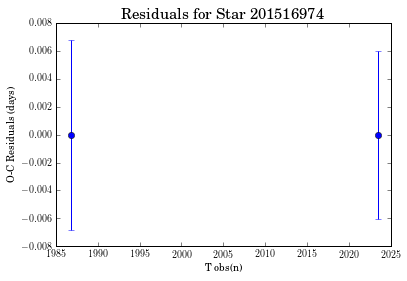


2 ) *************** Star 201920032  ***************

  -> Number of observed transits: 3

  -> Observed transit times:
[ 2000.20592428  2028.46719716  2056.74828266]

  -> Best linear fit of Observed Transit Times: 
Period =  28.27117919 days
t0 =  2000.20262218

  -> Optimal Values:
Period =  28.2707363144 +/- 0.00398961214749
Transit Time =  2000.2047406 +/- 0.00469581407939
 


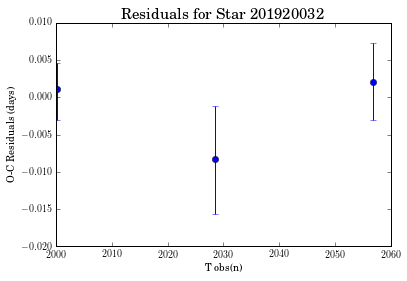


3 ) *************** Star 205924614  ***************

  -> Number of observed transits: 19

  -> Observed transit times:
[ 2150.42409694  2156.12197489  2158.9714867   2161.82072446  2164.66795198
  2170.36755541  2173.21693895  2176.06548744  2178.91425179  2181.76358963
  2184.6141442   2187.46287966  2190.31353283  2193.16317082  2196.0112458
  2198.86009608  2201.71049742  2204.55899131  2207.40938719]

  -> Best linear fit of Observed Transit Times: 
Period =  3.06922182035 days
t0 =  2153.2421617

  -> Optimal Values:
Period =  3.07117516736 +/- 0.0422156289332
Transit Time =  2153.14380753 +/- 0.441803285584
 


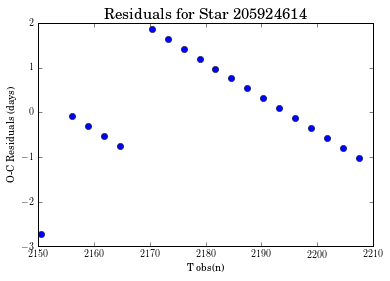


4 ) *************** Star 206029314  ***************

  -> Number of observed transits: 10

  -> Observed transit times:
[ 2148.0691844   2155.09507858  2162.11980159  2169.1463519   2176.17262262
  2183.19764832  2190.2235004   2197.25009619  2204.27621952  2211.30195231]

  -> Best linear fit of Observed Transit Times: 
Period =  7.02588389073 days
t0 =  2148.06876807

  -> Optimal Values:
Period =  7.02583841052 +/- 4.85230789017e-05
Transit Time =  2148.06903379 +/- 0.000214182171157
 


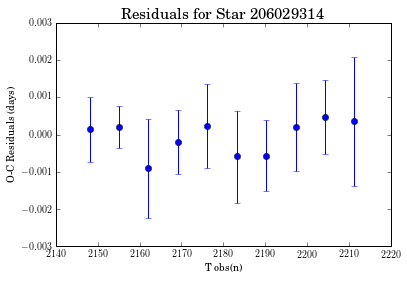


5 ) *************** Star 206061524  ***************

  -> Number of observed transits: 9

  -> Observed transit times:
[ 2153.32286787  2159.20341281  2165.08369367  2170.96235057  2176.84244951
  2188.60189888  2194.47809666  2206.2371505   2212.12302156]

  -> Best linear fit of Observed Transit Times: 
Period =  7.54550303533 days
t0 =  2150.57964808

  -> Optimal Values:
Period =  7.36010912959 +/- 0.3363018914
Transit Time =  2150.91931417 +/- 1.36789613456
 


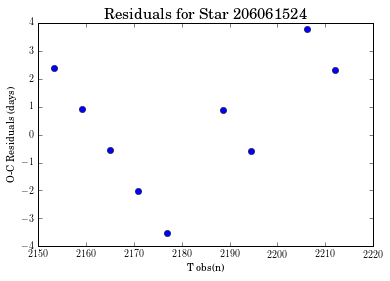


6 ) *************** Star 206082454  ***************

  -> Number of observed transits: 2

  -> Observed transit times:
[ 2160.54008315  2190.16613678]

  -> Best linear fit of Observed Transit Times: 
Period =  29.62605363 days
t0 =  2160.54008315

  -> Optimal Values:
Period =  29.62605363 +/- 0.0
Transit Time =  2160.54008315 +/- 0.0
 


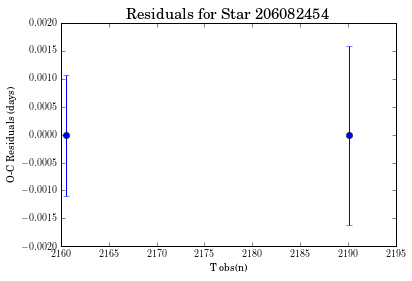


7 ) *************** Star 206155547  ***************

  -> Number of observed transits: 3

  -> Observed transit times:
[ 2152.88399927  2177.27253274  2201.65845314]

  -> Best linear fit of Observed Transit Times: 
Period =  24.387226935 days
t0 =  2152.88443478

  -> Optimal Values:
Period =  24.3874161985 +/- 0.000604764080081
Transit Time =  2152.88411735 +/- 0.000542786621097
 


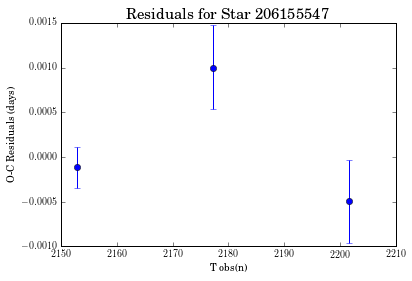


8 ) *************** Star 206245553  ***************

  -> Number of observed transits: 8

  -> Observed transit times:
[ 2154.67125465  2162.17096198  2169.66309965  2177.16830107  2184.65593305
  2192.14512031  2199.64630652  2207.14025616]

  -> Best linear fit of Observed Transit Times: 
Period =  7.49515984798 days
t0 =  2154.67459471

  -> Optimal Values:
Period =  7.49552704944 +/- 0.000503427946893
Transit Time =  2154.67245231 +/- 0.00159095236909
 


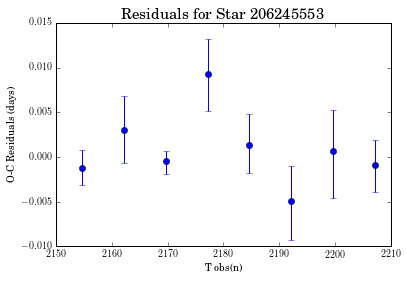

In [112]:
count = 1

for star in new_targets:
    t0 = np.loadtxt('2_'+star.name+'t0_mcmc.txt', skiprows=1)
    t0_obs = t0[:,0]
    t0_uppererr = t0[:,1]
    t0_lowererr = t0[:,2]
    print count, ") *************** Star", star.name, " ***************"
    print ""
    print "  -> Number of observed transits:", len(star.transits)
    print ""
    print "  -> Observed transit times:"
    print t0_obs
    print ""
    
    opt_values, err = oc(star, t0_obs, t0_uppererr, t0_lowererr)
    
    print ""
     
    #np.savetxt('2_'+star.name+'finalp0t0.txt', np.transpose([opt_values,err]), fmt='%.10f', 
    #          delimiter = ' ', header = """Column 1 shows the period (row 1) and its uncertainty (row 2). 
    #           Column 2 gives t0 (row 1) and its uncertainty (row 2). Light curves with only two
    #           transits have uncertainties equal to 0.0. This is NOT because 0.0 is their 
    #           actual value, but because we couldn't calculate it with only two points.
    #           """)
    
    count += 1

In [114]:
def func(x, a, b): 
    return (a*x + b)

def oc(star, obst0, upper_error, lower_error):
    
    n = np.empty(len(star.transits))
    tobs = np.empty(len(star.transits))
    tobsErr = np.empty(len(star.transits))
    
    for i in range(0,len(n)):
        n[i] = i
          
    for i in range (len(star.transits)):
        aux = obst0[i]
        auxerr = (upper_error[i] + lower_error[i])/2 
        tobs[i] = aux
        tobsErr[i] = auxerr 
  
    k = np.polyfit(n, tobs, 1) #Linear fit 
   
    slopeP = k[0]
    t0Final = k[1]
    
    print "  -> Best linear fit of Observed Transit Times: "
    print "Period = ", slopeP, "days"
    print "t0 = ", t0Final
    print ""
    
    popt, pcov = op.curve_fit(func, n, tobs, p0 = [slopeP, t0Final], sigma = tobsErr)
    
    """
        popt: Optimal values for the parameters so that the sum of the squared error of "f(xdata, *popt) - ydata" 
        is minimized. (Array)

        pcov: The estimated covariance of popt. The diagonals provide the variance of the parameter estimate. 
        To compute one standard deviation errors on the parameters use perr = np.sqrt(np.diag(pcov)). (2D Array)
    """
    perr = np.sqrt(np.diag(pcov)) #Entry 0 = Error of period; Entry 1 = Error of t0
    
    if len(star.transits) == 2: # With 2 points, can't calculate the error
        perr[0] = 0.0
        perr[1] = 0.0 #To be improved.

    print "  -> Optimal Values:"
    print "Period = ", popt[0], "+/-", perr[0]
    print "Transit Time = ", popt[1], "+/-", perr[1]
    print " "
    
    o_c = np.array(tobs) - popt[1] - popt[0]*np.array(n) # residuals = t obs(n) - t0 - P*n'
   
    plt.figure()
    asymmetric_error = [lower_error, upper_error]
    
    plt.errorbar(tobs, o_c, yerr = asymmetric_error, fmt='o')
    plt.xlabel('T obs(n)')
    plt.ylabel('O-C Residuals (days)') #Residuals t obs(n) - t0 - P*n'
    plt.title('Residuals for Star '+ star.name, fontsize = 15)
    plt.show()
    
    return popt, perr